# Assignment 9: Adversarial Examples

In [8]:
# enter your name and UFL email address
name = 'enter your name'
email = 'enter your email'

name = 'solution' # ###- 
email = 'solution' # ###- 

In [9]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 9 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time

    import numpy as np
    import sklearn
    
    # we'll use tensorflow and keras for neural networks
    import tensorflow as tf
    import tensorflow.keras as keras
    
    # import layers we may use
    from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout

    # import callbacks we may use
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
    
    # Load the TensorBoard notebook extension
    #%load_ext tensorboard

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### NumPy version: ' + np.__version__)
    print('### Scikit-learn version: ' + sklearn.__version__)
    print('### Tensorflow version: ' + tf.__version__)
    print('### TF Keras version: ' + keras.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots
    import nets

Assignment 9 -- name: solution, email: solution

### Python version: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
### NumPy version: 1.19.5
### Scikit-learn version: 0.24.0
### Tensorflow version: 2.4.0
### TF Keras version: 2.4.0
------------


In [10]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

## We'll use the Fashion-MNIST data

In [11]:
from tensorflow.keras.datasets import fashion_mnist
def load_preprocess_fashion_mnist(minmax_normalize=True):
    
    labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    train, testval = fashion_mnist.load_data()
    
    train_x, train_y = train
    testval_x, testval_y = testval
    
    if minmax_normalize:
        train_x = train_x / 255.0
        testval_x = testval_x / 255.0
    
    # split test - val
    nval = testval_x.shape[0] // 2
    
    val_x = testval_x[:nval]
    val_y = testval_y[:nval]
    
    test_x = testval_x[nval:]
    test_y = testval_y[nval:]
    
    if len(train_x.shape) < 4:
        train_x = train_x.reshape(-1, 28, 28, 1)
        val_x = val_x.reshape(-1, 28, 28, 1)
        test_x = test_x.reshape(-1, 28, 28, 1)
    
    return train_x, train_y, test_x, test_y, val_x, val_y, np.array(labels)

In [14]:
train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_fashion_mnist()

## [Task 1] (20 points) Splitting the data

### To simulate an adversary not having access to exactly the same data as the people training the model, we'll split train and val into two disjoint subsets.

### [Task 1a] (20 points) Complete the implementation below to split the data as instructed.

In [15]:
prop_target = 0.6
tr_sz = int(train_x.shape[0] * prop_target)
vl_sz = int(val_x.shape[0] * prop_target)

### 1. take the first tr_sz records of train_x/y and store that in 'tr_x', 'tr_y'
### 2. take the first vl_sz records of val_x/y and store that in 'vl_x', 'vl_y'
### 3. take the remaining records (tr_sz, tr_sz + 1, ...) of train_x/y and store that in 'adv_tr_x', 'adv_tr_y'
### 4. take the remaining records (vl_sz, vl_sz + 1, ...) of val_x/y and store that in 'adv_vl_x', 'adv_vl_y'

###* Put your code here (~8 lines) *###
tr_x = train_x[:tr_sz]
tr_y = train_y[:tr_sz]

vl_x = val_x[:vl_sz]
vl_y = val_y[:vl_sz]

adv_tr_x = train_x[tr_sz:]
adv_tr_y = train_y[tr_sz:]

adv_vl_x = val_x[vl_sz:]
adv_vl_y = val_y[vl_sz:]


# delete this so we don't accidentally use them
del train_x, train_y, val_x, val_y

### Let's train the target model (CNN)

In [17]:
def create_compile_cnn(input_shape=[28, 28, 1], num_outputs=10, verbose=False):
    
    name = 'Target-CNN'    
    model = keras.models.Sequential(name=name)
    
    model.add(Conv2D(64, kernel_size=(7,7), input_shape=input_shape,
                     padding='same', activation='relu', name='conv1'))
    model.add(MaxPooling2D((2,2), name='maxpool1')) 
    
    model.add(Conv2D(12, kernel_size=(3,3), activation='relu', padding='same', name='conv2'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv3'))
    model.add(MaxPooling2D(2, name='maxpool2'))
    
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv4'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv5'))
    model.add(MaxPooling2D(2, name='maxpool3'))
    
    model.add(Flatten(name='flatten'))
    
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(Dropout(0.5, name='dropout1'))
    model.add(Dense(64, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    
    model.add(Dense(num_outputs, activation="softmax", name='output'))
    
    opt = keras.optimizers.Adam(lr=0.002)
    
    if verbose:
        model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

### Train the target model (or load it)
#### To save time, you can use the provided model file.

In [18]:
target_model_fp = 'target-fashion-MNIST-CNN.h5'
load = os.path.exists(target_model_fp)

if load:
    target_model = tf.keras.models.load_model(target_model_fp)
else:
    _, target_model = create_compile_cnn(verbose=True)

    early_stop_cb = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    max_epochs = 10
    batch_size = 64

    history = target_model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

    # save the model
    target_model.save(target_model_fp)

## [Task 2] (30 points) Code for untargeted aversarial examples

### [Task 2a] (5 points) Set the target model to be non-trainable (so we don't accidentally update the weights)

In [9]:
### make sure the target model is not trainable
###* Put your code here (~1 line) *###
target_model.trainable = False

### Let's set up some code for the attack

In [10]:
# get predicted label and confidence value for it
def pred_label_and_conf(model, x):
    preds = model.predict(x)[0]
    pred_label = np.argmax(preds)
    pred_conf = preds[pred_label]
    
    return pred_label, pred_conf

### [Task 2b] (5 points) Fill in the implementation of gradient_of_loss_wrt_input()

In [11]:
# this should return the gradient of the loss (sparse categorical crossentropy with y_target) with respect to 'in_x'
# you should use gradient tape and return the gradient from the tape
def gradient_of_loss_wrt_input(model, in_x, y_target):
    ###* Put your code here (~5 lines) *###
    with tf.GradientTape() as tape:
        tape.watch(in_x) # tell the tape to watch in_x
        y_pred = model(in_x) # get the prediction on the model
        loss = keras.losses.sparse_categorical_crossentropy(y_target, y_pred) # compute the loss
        
    return tape.gradient(loss, in_x) # gradient of the loss with respect to the input

### [Task 2c] (20 points) Fill in the implementation of fgsm_untargeted().

#### Note: in exercise 11 we implemented the targeted version of this attack (i.e., we wanted the adversarial example to be classified as the target label). Here, we want the untargeted version (i.e., we just want the adversarial example to have a different predicted label than 'in_y'). 

In [12]:
# Implement the Fast Gradient Sign Method (FGSM) for untargetted perturbations
def fgsm_untargeted(model, in_x, in_y, eps):
    ### Use gradient_of_loss_wrt_input() to get the gradient vector
    ### Then calculate a perturbation (using the sign of the gradient) to increase the loss on 'in_x' for the *true* label ('in_y') 
    ### Finally add that perturbation scaled by eps to the input image and clip it so it results in a valid image ('adv_x')
    ###* Put your code here (~3-4 lines) *###
    grad_vec = gradient_of_loss_wrt_input(model, in_x, in_y)
    
    perturb = tf.sign(grad_vec)
    adv_x = in_x + eps * perturb
    adv_x = tf.clip_by_value(adv_x, 0, 1.0)
    
    return adv_x

### Plotting code

In [13]:
def plot_adversarial_example(model, orig_x, adv_x):
    perturb = adv_x - orig_x
    
    # compute confidence
    in_label, in_conf = pred_label_and_conf(model, orig_x)
    
    # compute confidence
    adv_label, adv_conf = pred_label_and_conf(model, adv_x)
    
    titles = ['Label: {} (conf: {:.3f})'.format(in_label, in_conf), 'Perturbation',
              'Label: {} (conf: {:.3f})'.format(adv_label, adv_conf)]
    
    images = np.r_[orig_x, perturb, adv_x]
    
    # plot images
    plots.plot_images(images, dim_x=28, dim_y=28, fig_size=(8,3), titles=titles, titles_fontsize=12)

## [Task 3] (35 points) Producing adversarial examples

In [14]:
# Take the first example of test
in_x = test_x[0].reshape(-1, 28, 28, 1)
in_y = test_y[0]

in_pred, in_conf = pred_label_and_conf(target_model, in_x)
print('First test example -> true label: {}, pred label: {} [confidence: {:.2f}%]'.format(in_y, in_pred, 100*in_conf))

Last test example -> true label: 2, pred label: 2 [confidence: 99.06%]


### [Task 3a] (5 points) Complete the implementation below to split to produce an adversarial example using one step of untargeted FGSM.

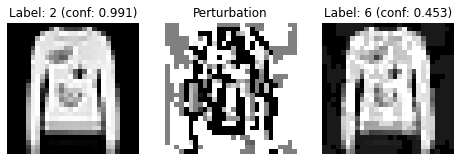

In [15]:
eps = 0.1

### Use fgsm_untargeted() on the target model to create an adversarial example for in_x/y. Call it 'adv_x'
###* Put your code here (~2-3 lines) *###

# we need it to be a tensor so we can take the gradient of the loss with respect to it
adv_x = tf.convert_to_tensor(in_x, dtype=tf.float32)

# do one step of FGSM
adv_x = fgsm_untargeted(target_model, adv_x, in_y, eps)


# plot the adversarial example
plot_adversarial_example(target_model, in_x, adv_x)

### [Task 3b] (10 points) What is the predicted class label and confidence? Does the perturbation make the adversarial image look different to you?

In [16]:
###* put your answer here *###
#
# Predicted label is 6 ('shirt') and confidence is 0.453.
#
# The adversarial image does not look significantly different, maybe a bit noisy but that's it.
#


### [Task 3c] (5 points) Complete the implementation of the stop function.

In [17]:
# return True if:
# the maximum number of iteration is reached 
# or if the adversarial label is different from the original label and confidence is above the threshold
# otherwise return False
def stop_fn(i, adv_x, orig_label, adv_label, adv_conf, max_iter, threshold):
    ####* put your code here (~1-3 lines) *###
    if i >= max_iter or (orig_label != adv_label and adv_conf >= threshold):
        return True
    return False

In [18]:
def iterative_fgsm_untargeted(model, in_x, in_y, eps, stop_fn):
    adv_x = tf.convert_to_tensor(in_x, dtype=tf.float32) # convert to tensor

    i = 0
    while True:
        # do one step of FGSM
        adv_x = fgsm_untargeted(model, adv_x, in_y, eps)

        # check if predicted label is the target
        adv_label, adv_conf = pred_label_and_conf(model, adv_x)

        # call the stop_fn and exit if needed
        if stop_fn(i, adv_x, in_y, adv_label, adv_conf):
            break
        
        # don't forget to increment 1
        i += 1
            
    return adv_x

### Adversarial example on iterated FGSM

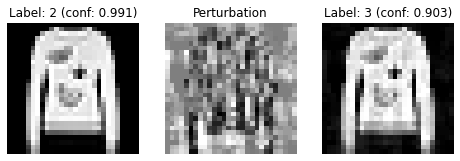

In [19]:
# Take the first example of test
in_x = test_x[0].reshape(-1, 28, 28, 1)
in_y = test_y[0]

# use a smaller epsilon...
eps = 0.005

the_stop_fn = lambda i, ax, ol, al, ac: stop_fn(i, ax, ol, al, ac, 200, 0.9)
adv_x = iterative_fgsm_untargeted(target_model, in_x, in_y, eps, the_stop_fn)

# plot the adversarial example
plot_adversarial_example(target_model, in_x, adv_x)

### [Task 3d] (5 points) Did the attack work? What is the predicted label and confidence?

In [20]:
###* put your answer here *###
#
# Yes, the attack worked. The predicted label is 3 ('dress') and confidence is above 0.9
#
#

### For the rest of this task, we will simulate the case where the adversary does not have access to the target model. So he must train a substitute model (of a similar but different architecture) on a different subset of the data. Then the adversary will use the substitute model to craft adversarial examples.

In [21]:
def create_compile_substitute_cnn(input_shape=[28, 28, 1], num_outputs=10, verbose=False):
    
    name = 'Substitute-CNN'    
    model = keras.models.Sequential(name=name)
    
    model.add(Conv2D(32, kernel_size=(7,7), input_shape=input_shape,
                     padding='same', activation='relu', name='conv1'))
    model.add(MaxPooling2D((2,2), name='maxpool1')) 
    
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', name='conv2'))
    model.add(MaxPooling2D(2, name='maxpool2'))
    
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv3'))
    model.add(MaxPooling2D(2, name='maxpool3'))
    
    model.add(Flatten(name='flatten'))
    
    model.add(Dense(196, activation='relu', name='fc1'))
    model.add(Dropout(0.5, name='dropout1'))
    model.add(Dense(96, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    
    model.add(Dense(num_outputs, activation="softmax", name='output'))
    
    opt = keras.optimizers.Adam(lr=0.002)
    
    if verbose:
        model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

### Let's train the substitute model (sub_model). Notice that the training data is 'adv_tr_x'/'adv_tr_y'.

#### To save time, you can use the provided model file.

In [22]:
sub_model_fp = 'substitute-fashion-MNIST-CNN.h5'
load = os.path.exists(sub_model_fp)

if load:
    sub_model = tf.keras.models.load_model(sub_model_fp)
else:
    _, sub_model = create_compile_substitute_cnn(verbose=True)

    early_stop_cb = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    max_epochs = 10
    batch_size = 32

    history = sub_model.fit(adv_tr_x, adv_tr_y, validation_data=(adv_vl_x, adv_vl_y), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

    # save the model
    sub_model.save(sub_model_fp)

sub_model.trainable = False

### [Task 3e] (5 points) Complete the implement of the attack below.

--- Substitute Model ---


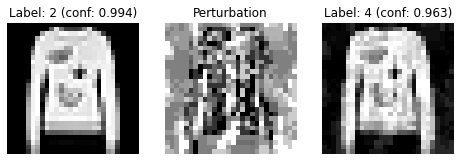

--- Target Model ---


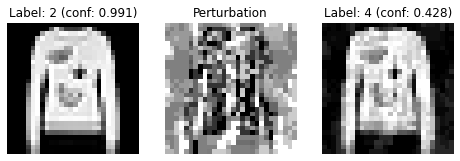

In [23]:
# Take the first example of test
in_x = test_x[0].reshape(-1, 28, 28, 1)
in_y = test_y[0]

eps = 0.03

### Use iterative_fgsm_untargeted on the *substitute model* to create an adversarial example for in_x/y. 
### Call it 'adv_x'. We will then check if this adversarial example transfers.
### Use max_iter=200 and conf_threshold=0.95
###* Put your code here (~1-2 lines) *###
the_stop_fn = lambda i, ax, ol, al, ac: stop_fn(i, ax, ol, al, ac, 200, 0.95)
adv_x = iterative_fgsm_untargeted(sub_model, in_x, in_y, eps, the_stop_fn)


# Let's look at the adversarial example and the perturbation
print('--- Substitute Model ---')
plot_adversarial_example(sub_model, in_x, adv_x)
print('--- Target Model ---')
plot_adversarial_example(target_model, in_x, adv_x)

### [Task 3f] (5 points) Did the attack work? Did your adversarial example successfully transfer? (Justify your answer.)

In [24]:
###* put your answer here *###
#
# Yes, the adversarial example transfered. 
# It is also misclassified by the target model and the predicted class label is the same.
#
#

## [Task 4] (15 points) Creating noise that looks like a specific class to the target model.

### [Task 4a] (5 points) Produce images with uniformly random pixel values in [0,1]. Store the result in 'noise_x'.

In [25]:
num_samples = 64

### Sample 'num_samples' random noise 'images' and store this in 'noise_x'. 
### The shape of each image should be identitical to those in tr_x, vl_x, test_x, etc...
###* Put your code here (~1-2 lines) *###
noise_x = np.random.uniform(low=0.0, high=1.0, size=(num_samples, 28, 28, 1))

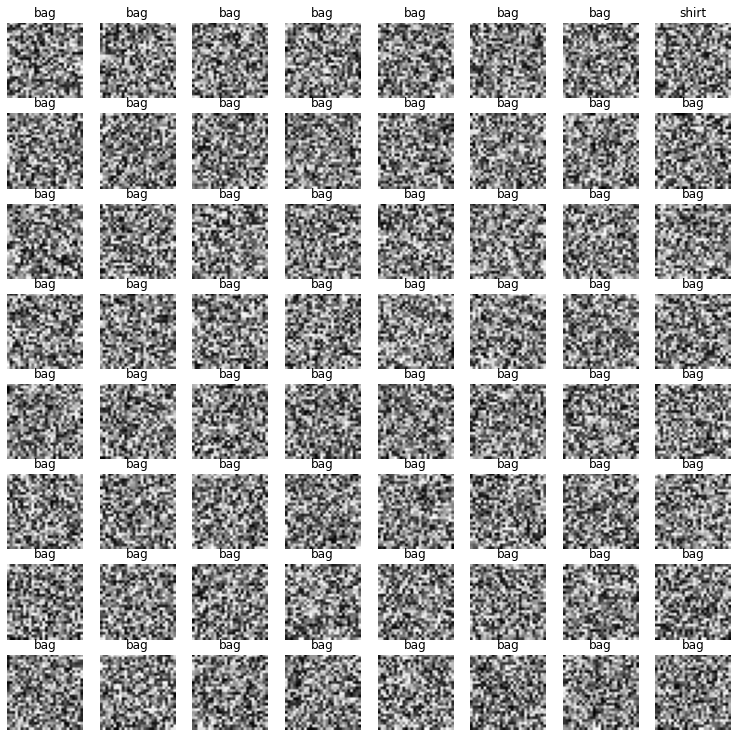

In [26]:
titles = labels[np.argmax(target_model.predict(noise_x), axis=1)]
plots.plot_images(noise_x[:num_samples].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(13,13), titles=titles)

### [Task 4b] (5 points) What is the most common label? Is that expected?

In [27]:
###* put your answer here *###
#
# The most common label is bag. 
# It's not expected but the model has to assign some label to images that look like noise.
#

### [Task 4c] (5 points) Implement move_towards_class().

In [28]:
def move_towards_class(model, in_x, target_label, eps):
    ### Take a step the direction of target label. Clip the result so you output a valid image ('out_x')
    ###* Put your code here (~3-5 lines) *###
    grad_vec = gradient_of_loss_wrt_input(model, in_x, target_label)
    
    perturb = tf.sign(-grad_vec)
    out_x = in_x + eps * perturb
    out_x = tf.clip_by_value(out_x, 0, 1.0)
    
    return out_x

In [29]:
max_iter = 100
eps = 0.06
target_label = 0

print('Taking steps towards label {} ({})'.format(target_label, labels[target_label]))

# initialize output
output_x = np.zeros_like(noise_x)
for i, in_x in enumerate(noise_x):
    
    # we need it to be a tensor so we can take the gradient of the loss with respect to it
    adv_x = tf.convert_to_tensor(in_x.reshape(1, 28, 28, 1), dtype=tf.float32)

    for j in range(0, max_iter):
        # move one step
        adv_x = move_towards_class(target_model, adv_x, target_label, eps)
        
        # check if predicted label is the target
        adv_label, adv_conf = pred_label_and_conf(target_model, adv_x)
        
        if adv_label == target_label:
            break
    
    output_x[i] = adv_x

Taking steps towards label 0 (top)


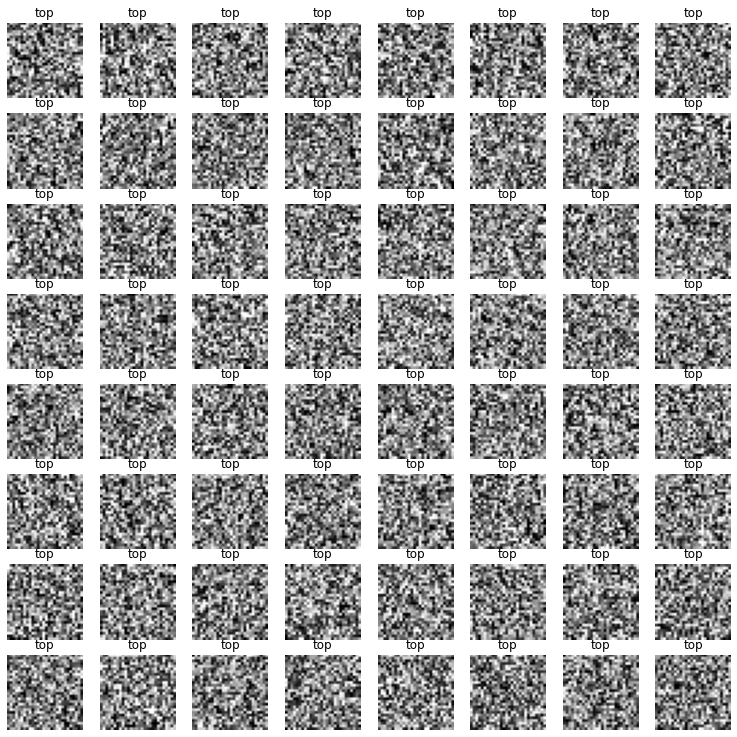

In [30]:
titles = labels[np.argmax(target_model.predict(output_x), axis=1)]
plots.plot_images(output_x[:num_samples].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(13,13), titles=titles)

## [CIS6930 Additional Task -- Task 5] (25 points): Single Pixel Attacks

### For this task, you will implement a single pixel adversarial example attack. Specifically, this is an iterative that modifies a single pixel of an image at each iteration until the resulting perturbed image is classified as desired by the target model.

### [Task 5a] (25 points) Fill in the implementation below of single_pixel_attack_step() and iterative_single_pixel_attack()

In [31]:
# Single pixel attack
def single_pixel_attack_step(model, in_x, target_y, eps):
    ### Use gradient_of_loss_wrt_input() to get the gradient vector
    ### Then figure out the pixel which would have the greatest impact and only perturb this pixel
    ### scaled by eps. Clip the result so you get a valid image
    ###* Put your code here (~3-4 lines) *###
    grad_vec = gradient_of_loss_wrt_input(model, in_x, target_y)
    
    pixel_idx = np.unravel_index(np.argmax(-grad_vec), grad_vec.shape)
    perturb = np.zeros_like(grad_vec)
    perturb[pixel_idx] = tf.sign(-grad_vec[pixel_idx])
    adv_x = in_x + eps * perturb
    adv_x = tf.clip_by_value(adv_x, 0, 1.0)
    
    return adv_x

def iterative_single_pixel_attack(model, in_x, target_y, eps, max_iter=25, conf_threshold=0.7):
    adv_x = tf.convert_to_tensor(in_x, dtype=tf.float32)
    
    ### In a loop of at most max_iter iterations, use single_pixel_attack_step() to produce a perturbation
    ### In each iteration, get the predicted label of the current adversarial image and confidence
    ### if the predicted label matches the target ('target_y') and the confidence is above the 
    ### threshold ('conf_threshold') your attack should exit.
    ### This function should return the adversarial image 'adv_x'
    ###* Put your code here (~4-6 lines) *###
    for i in range(0, max_iter):
        # do one step of the single pixel attack
        adv_x = single_pixel_attack_step(model, adv_x, target_y, eps)

        # check if predicted label is the target
        adv_label, adv_conf = pred_label_and_conf(model, adv_x)

        # call the stop_fn and exit if needed
        if adv_label == target_y and adv_conf > conf_threshold:
            break
            
    return adv_x

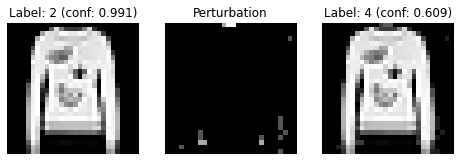

In [32]:
target_y = 4
eps = 0.12

### Take the first example of test
in_x = test_x[0].reshape(-1, 28, 28, 1)
in_y = test_y[0]

adv_x = iterative_single_pixel_attack(target_model, in_x, target_y, eps)

plot_adversarial_example(target_model, in_x, adv_x)